# Implementation of Contrastive-sc using PBMC 10X 4k dataset in order to reproduce paper results

## Import useful modules

In [1]:
!pip install scanpy
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip3 install igraph
!pip3 install leidenalg
!pip install os
!pip install csv
!pip install random

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement csv (from versions: none

In [2]:
from keras import layers
from keras.layers import Layer
from keras.models import load_model, Model
from keras import backend as K
from keras.losses import KLDivergence
import numpy as np
import scanpy as sc
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from layers import ConstantDispersionLayer, SliceLayer, ColWiseMultLayer
import keras
from keras.layers import Layer
from sklearn.model_selection import train_test_split
import datetime
import time
import os
import csv
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.metrics.pairwise import euclidean_distances
import math
import random
import h5py

2024-07-06 18:06:13.608708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-06 18:06:20.291292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.__version__

'2.16.1'

In [4]:
keras.__version__

'3.3.3'

## Preprocessing

### Load dataset

Import dataset PBMC 4k and check the data

In [6]:
filename="./dataset/10X_PBMC.h5"
with h5py.File(filename, 'r') as f :
    data_X=f['X'][:]
    data_Y=f['Y'][:]
    df_X=pd.DataFrame(data_X)
    df_Y=pd.DataFrame(data_Y)
    
df_X

,0,1,2,3,4,5,6,7,8,9,...,16643,16644,16645,16646,16647,16648,16649,16650,16651,16652
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4267,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_Y.columns=['label']
df_Y["label"]=df_Y['label'].astype(str)
df_Y

,label
0,2
1,2
2,2
3,8
4,3
...,...
4266,6
4267,5
4268,7
4269,3


In [8]:
df_Y["label"].value_counts()

label
1    1292
2     702
3     606
4     459
5     450
6     332
7     295
8     135
Name: count, dtype: int64

In [9]:
data_ann=sc.AnnData(df_X)
data_ann

/shared/home/tberthet/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/shared/home/tberthet/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4271 × 16653

In [10]:
data_ann.obs=df_Y

### Filter data

On filtre les données de manière peu stricte

In [11]:
sc.pp.filter_cells(data_ann, min_genes=1)
sc.pp.filter_genes(data_ann, min_cells=1)

/shared/home/tberthet/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
#make a copy of the raw matrix before normalizing
data_ann.raw = data_ann.copy()

In [13]:
data_ann

AnnData object with n_obs × n_vars = 4271 × 16653
    obs: 'label', 'n_genes'
    var: 'n_cells'

### Normalize and scale

In [14]:
#normalize
sc.pp.normalize_total(data_ann)

#compute size factor
data_ann.obs['size_factors'] = data_ann.obs.n_genes / np.median(data_ann.obs.n_genes)
#data_ann.obs['size_factors'] = 1.0

#log transform
sc.pp.log1p(data_ann)

Features selection : selection of high variable genes

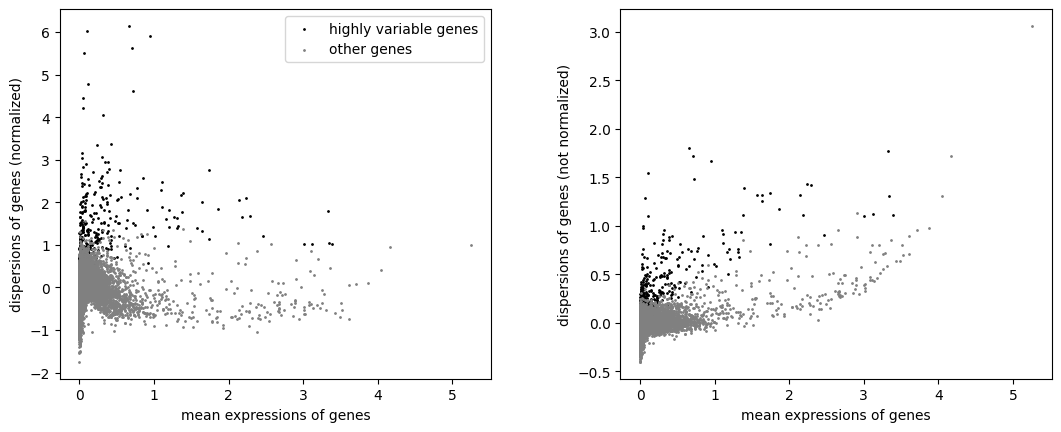

In [15]:
sc.pp.highly_variable_genes(data_ann, n_top_genes=500, batch_key="label")
sc.pl.highly_variable_genes(data_ann)

In [16]:
# scale the data
sc.pp.scale(data_ann)

### Explore the result

In [17]:
data_ann.X

array([[-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       ...,
       [-0.04478425, -0.36973775, -0.22519336, ..., 16.46698363,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358]])

In [18]:
data_ann.n_vars

16653

In [19]:
data_ann.X

array([[-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       ...,
       [-0.04478425, -0.36973775, -0.22519336, ..., 16.46698363,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358]])

In [20]:
data_ann.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std
0,9,False,0.002611,-0.013101,-0.060134,0,False,0.001286,0.028724
1,570,False,0.135255,-0.001270,0.209814,0,False,0.091207,0.246681
2,225,False,0.050292,-0.021517,0.112911,0,False,0.034340,0.152490
3,12,False,0.001860,-0.149268,-0.466780,0,False,0.001729,0.033887
4,106,False,0.024858,0.030561,0.267766,1,False,0.016371,0.106600
...,...,...,...,...,...,...,...,...,...
16648,322,False,0.070651,0.029831,0.317225,1,False,0.050375,0.184955
16649,78,False,0.018880,0.000764,0.153966,1,False,0.011738,0.090542
16650,9,False,0.001481,-0.250185,-1.141559,0,False,0.001020,0.023021
16651,15,False,0.003912,-0.137269,-0.271806,0,False,0.002027,0.036117


In [21]:
data_ann.obs

,label,n_genes,size_factors
0,2,748,0.607636
1,2,1052,0.854590
2,2,739,0.600325
3,8,874,0.709992
4,3,951,0.772543
...,...,...,...
4266,6,1807,1.467912
4267,5,1249,1.014622
4268,7,2223,1.805849
4269,3,983,0.798538


In [22]:
data_ann.raw.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Get only the data corresponding to the high variable genes

In [23]:
# get the preprocessed count matrix of the high variables genes only
highly_variable_genes = data_ann.var[data_ann.var['highly_variable']].index.tolist()
count_data_hvg = data_ann[:, highly_variable_genes].X
count_data_hvg=count_data_hvg.toarray()
count_data_hvg

array([[ 2.43124879, -0.14809046, -0.19217715, ...,  1.68828923,
         1.55773585, -0.09001358],
       [-0.53800062, -0.14809046, -0.19217715, ...,  1.13904774,
         0.75317683, -0.09001358],
       [-0.53800062, -0.14809046, -0.19217715, ...,  2.07421344,
         1.7336189 , -0.09001358],
       ...,
       [ 1.1276868 , -0.14809046, -0.19217715, ..., -0.83583182,
        -0.56730305, -0.09001358],
       [ 1.59388979, -0.14809046, -0.19217715, ..., -0.82391394,
        -1.13425163, -0.09001358],
       [-0.53800062, -0.14809046, -0.19217715, ...,  1.19314461,
         1.33492008, -0.09001358]])

## Create autoencoder

In [25]:
def create_contrastive_encoder(input_dim, dims, dropout=0.8):
    """
    Create the encoder architecture
    
    Inputs :
        input_dim (int) : input shape
        dims (list of int) : size of the enoder layers
        dropout (float from 0 to 1) : rate of dropout
    """
    Inputs = layers.Input(shape=(input_dim,))
    x = layers.Dropout(rate=dropout)(Inputs)  # L'argument input_shape n'est pas nécessaire ici
    for i in range(len(dims) - 1):
        x = layers.Dense(dims[i], kernel_initializer='glorot_uniform')(x)
        x = layers.BatchNormalization(epsilon=1e-5, momentum=0.1)(x)
        x = layers.ReLU()(x)
    
    x = layers.Dense(dims[-1],  kernel_initializer='glorot_uniform')(x)
    x = layers.Lambda(lambda y: tf.nn.l2_normalize(y, axis=1))(x)
    model = Model(Inputs, x)
    return model

In [26]:
def SupConLoss(features, labels=None, mask=None, temperature=0.07, base_temperature=0.07, contrast_mode='all'):
    """
    Computes the Supervised Contrastive Loss 

    Inputs:
        features (tf.Tensor): Feature representations of shape [batch_size, n_views, ...].
        labels (tf.Tensor): Ground truth labels of shape [batch_size]. Default is None.
        mask (tf.Tensor): Contrastive mask of shape [batch_size, batch_size]. Default is None.
        temperature (float): Temperature scaling parameter. Default is 0.07.
        base_temperature (float): Base temperature scaling parameter. Default is 0.07.
        contrast_mode (str): Mode of contrastive computation, either 'one' or 'all'. Default is 'all'.

    Output:
        loss: The computed loss value.
    """
    
    # Check if the features have at least 3 dimensions
    if len(features.shape) < 3:
        raise ValueError('`features` needs to be [bsz, n_views, ...], at least 3 dimensions are required')
    
    # Reshape features if they have more than 3 dimensions
    if len(features.shape) > 3:
        features = tf.reshape(features, [tf.shape(features)[0], tf.shape(features)[1], -1]) 
    
    batch_size = tf.shape(features)[0]

    # Ensure only one of `labels` or `mask` is provided
    if labels is not None and mask is not None:
        raise ValueError('Cannot define both `labels` and `mask`')
    elif labels is None and mask is None:
        # If neither `labels` nor `mask` are provided, use an identity matrix as mask
        mask = tf.eye(batch_size, dtype=tf.float32)
    elif labels is not None:
        # Create mask based on labels
        labels = tf.reshape(labels, (-1, 1))
        if labels.shape[0] != batch_size:
            raise ValueError('Num of labels does not match num of features')
        mask = tf.cast(tf.equal(labels, tf.transpose(labels)), dtype=tf.float32)
    else:
        # If only `mask` is provided, use it as is
        mask = tf.eye(batch_size, dtype=tf.float32)
    
    contrast_count = features.shape[1]
    contrast_feature = tf.reshape(tf.concat(tf.unstack(features, axis=1), axis=0), [-1, tf.shape(features)[2]])
    
    # Determine the anchor features based on contrast mode
    if contrast_mode == 'one':
        anchor_feature = features[:, 0]
        anchor_count = 1
    elif contrast_mode == "all":
        anchor_feature = contrast_feature
        anchor_count = contrast_count
    else:
        raise ValueError(f'Unknown mode : {contrast_mode}')
        
    # Compute the logits
    anchor_dot_contrast = tf.math.divide(tf.linalg.matmul(anchor_feature, contrast_feature, transpose_b=True), temperature)
    
    # Subtract the maximum logit for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    
    # Tile the mask
    mask = tf.tile(mask, [anchor_count, contrast_count])
    
    # Create logits mask to exclude self-contrast cases
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size * anchor_count, dtype=tf.float32)
    mask *= logits_mask
    
    # Compute the exponential logits
    exp_logits = tf.exp(logits) * logits_mask
    
    # Compute the log-probabilities
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))
    
    # Compute the mean of log-probabilities for positive samples
    mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / tf.reduce_sum(mask, axis=1)
    
    # Compute the final loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    loss = tf.reshape(loss, [anchor_count, batch_size])
    loss = tf.reduce_mean(loss)
    
    return loss

In [37]:
def auto_kmeans(encoder, x_counts, obs,n='auto',  plot=False):
    """
    Apply K-means clustering on the latent space latent to maximise the sum of the metrics
    
    Inputs :
        encoder : the encoder model
        x_counts : the input count matrix
        obs : true labels
        n : if auto, look for the best number of clusters otherwise use the n value given
        plot (bool) : if True show some plots, none otherwise
    
    Outputs :
        y_pred : clusters assignments from K-means clustering
        n (int) : the number of clusters
        kmeans.cluster_centers_ : clusters centers
    """
    y=obs
    ari=[]
    nmi=[]
    ca=[]
    x=[]
    if n=="auto":
        #apply K-means for 1 to 20 clusters
        for n in range (1,20):
            kmeans=KMeans(n_clusters=n, n_init=30, verbose=0)
            y_pred=kmeans.fit_predict(encoder.predict(x_counts, verbose=0))
            ari.append(adjusted_rand_score(y, y_pred))
            nmi.append(normalized_mutual_info_score(y, y_pred))
            ca.append(cluster_acc(y, y_pred))
            x.append(n)
        #choose the number of clusters that maximize the sum of the metrics
        somme_metriques = [x + y + z for x, y, z in zip(ari, nmi, ca)]
        n=(somme_metriques.index(max(somme_metriques))+1)
    
    kmeans=KMeans(n_clusters=n, n_init=20)
    y_pred=kmeans.fit_predict(encoder.predict(x_counts))
    
    #display some plots if needed
    if plot==True:
        predict_data=encoder.predict(x_counts)
        adata_latent = sc.AnnData(predict_data)
        obs_df = pd.DataFrame({'label': y})
        adata_latent.obs=obs_df
        adata_latent.obs["kmeans"]=y_pred
        sc.pp.neighbors(adata_latent)
        sc.tl.umap(adata_latent)
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,ari)
        plt.plot(x,nmi)
        plt.plot(x,ca)
        plt.xlabel("nombre de clusters")
        plt.ylabel("Score")
        plt.legend(labels=["ARI", "NMI", "CA"])
        ari = adjusted_rand_score(y, y_pred)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, y_pred)
        print("Normalized mutual info (NMI) :", nmi)
        ca=cluster_acc(y, y_pred)
        print("Clustering accuracy (CA) :", ca)
        sc.pl.umap( adata_latent, color=["kmeans"], legend_loc="on data")
        plt.plot()
    return y_pred, n, kmeans.cluster_centers_

def auto_leiden(encoder, x_counts, y, res="auto", plot=False):
    """
    Apply Leiden clustering on the latent space latent to maximise the sum of the metrics
    
    Inputs :
        encoder : the encoder model
        x_counts : the input count matrix
        y : the true labels
        res : if auto choose the resolution to maximize the sum of metrics 
            otherwise apply Leiden algorithm with the indicated resolution
        plot (bool) : if True show some plots, none otherwise
    
    Outputs :
        res : the retained resolution
        predict : the clusters assignments
        n_clusters (int) : the number of clusters
        cluster_centers : the clusters centers 
    """
    #create an anndata from the data in the latent space
    predict_data=encoder.predict(x_counts, verbose=0)
    adata_latent = sc.AnnData(predict_data)
    obs_df = pd.DataFrame({'label': y})
    adata_latent.obs=obs_df
    
    #compute neigbors and UMAP 
    sc.pp.neighbors(adata_latent, use_rep='X')
    sc.tl.umap(adata_latent)
    list_ari=[]
    list_nmi=[]
    list_ca=[]
    x=[]
    
    if res=="auto":
        #search for the best resolution
        for i in range (1,10):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            list_ca.append(cluster_acc(y, predict_cluster))
            x.append(i/100)
        for i in range (1,11):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/10)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            list_ca.append(cluster_acc(y, predict_cluster))
            x.append(i/10)
         #select the best resolution value
        somme_metriques = [x + y + z for x, y, z in zip(list_ari, list_nmi, list_ca)]
        res=x[somme_metriques.index(max(somme_metriques))]
        print("La résolution est de : ", res)
    #compute for the best resolution
    sc.tl.leiden(adata_latent, key_added="leiden_res_%.4f" % (res), resolution=res)
    predict=adata_latent.obs["leiden_res_%.4f" % (res)]
    
    
    #compute cluster center for initialization
    init_pred=np.asarray(predict,dtype=int)
    features=pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.shape[0]))
    Group=pd.Series(init_pred,index=np.arange(0,adata_latent.shape[0]),name="Group")
    Mergefeature=pd.concat([features,Group],axis=1)
    cluster_centers=np.asarray(Mergefeature.groupby("Group").mean())
    n_clusters=len(np.unique(init_pred))
    
    #display plots if required
    if plot==True:
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,list_ari)
        plt.plot(x,list_nmi)
        plt.plot(x,list_ca)
        plt.xlabel("nombre de clusters")
        plt.ylabel("Score")
        plt.legend(labels=["ARI", "NMI", "CA"])
        plt.plot()
        sc.pl.umap( adata_latent, color=["leiden_res_%.4f" % (res)], legend_loc="on data")
        ari = adjusted_rand_score(y, predict)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, predict)
        print("Normalized mutual info (NMI) :", nmi)
        ca=cluster_acc(y, predict)
        print("Clustering accuracy (CA) :", ca)
 
        #crosstab = pd.crosstab(predict,y)
        #sns.heatmap(crosstab, annot=True, cmap='Blues')
        #plt.ylabel('Clusters prédits')
        #plt.xlabel('Annotations réelles')
        #plt.title('Matrice de confusion')
        #plt.show()
    return res, predict, n_clusters, cluster_centers

def cluster_embedding(model, X, y, method=None, res='auto', n='auto', plot=False):
    """
    Realize the clustering according to the method (K-means or Leiden)
    
    Inputs :
        model : the encoder model
        X : the input count matrix
        y : the true labels
        method : the choosen method (leiden or kmeans)
        res (float)= the resolution for Leiden
        n (int) = the number of clusters for Kmeans
        plot (bool) : if yes, display some plots
        
    Outputs :
        res : the  selected resolution for Leiden
        y_pred : clustering assignments
        n_clusters (int) : number of clusters
        clusters_centers : centroids coordinates
        
    """
    if method=='leiden':
        res, y_pred, n_clusters, cluster_centers=auto_leiden(encoder=model, x_counts=X, y=y, res=res, plot=plot)
        return res, y_pred, n_clusters, cluster_centers
    elif method=='kmeans':
        y_pred, n_clusters, cluster_centers=auto_kmeans(encoder=model, x_counts=X, obs=y,n=n,  plot=plot)
        return res, y_pred, n_clusters, cluster_centers
    else:
        raise ValueError(f'Unknown method : {method}')
    

In [38]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.asarray(y_true)
   
    y_pred = np.asarray(y_pred)
    
    #Make sure it's an array of str
    y_true= y_true.astype(str)
    y_pred = y_pred.astype(str)
    
    # find unique labels
    labels = np.unique(np.concatenate((y_true, y_pred)))
    n_labels = len(labels)

    # Build the confusion matrix (cost matrix)
    cost_matrix = np.zeros((n_labels, n_labels), dtype=int)
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            cost_matrix[i, j] = np.sum((y_true == label_true) & (y_pred == label_pred))

    #solve the optimal bipartite correspondance problem
    row_ind, col_ind = linear_assignment(cost_matrix.max() - cost_matrix)

    # Compute the accuracy
    accuracy = np.sum([cost_matrix[i, j] for i, j in zip(row_ind, col_ind)]) / y_true.size

    return accuracy


In [39]:
ef save_results_to_csv(history, filename):
        """
    Save results in a CSV file
    
    Inputs :
        history (dictionary): data to be saved in a csv file
        filename (str): file path to the csv file
    """
    file_exists = os.path.isfile(filename)
    with open(filename, mode='a') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(history.keys())
        writer.writerow(history.values())
        
def check_existing_filename(filename):
    """
    Check if the file corresponding to the file name already exists,
    if so change the filename
    
    input : 
        filename (str) : file path 
        
    Output :
        filename (str) : final filename
    """
    base, ext = os.path.splitext(filename)
    counter = 1
    while os.path.exists(filename):
        filename = f"{base}_{counter}{ext}"
        counter += 1
    return filename

def save_plot_umap(model, x, y, y_pred, res, epoch, pdf_pages, train_val="train"):
    """
    Save UMAP plot of true labels and predicted labels on the same page of a PDF file
    
    Inputs :
        model : the encoder model
        x : the input count matrix of the model
        y : the true labels
        y_pred : the predicted labels
        res (float): the leiden resolution
        epoch (int): the number of epoch of the model has been trained
        pdf_pages (str): the PDF file path
        train_test (str) : type of data used for the plot (train, val or test)
    """
    #Data retrieval and projection into latent space   
    predict_data=model.predict(x, verbose=0)
    obs_df = pd.DataFrame({'label': y})
    
    #Preparing data for Scanpy
    adata_latent = sc.AnnData(X=predict_data)
    adata_latent.obs = obs_df
    adata_latent.obs['predict'] = y_pred.astype(str)

    sc.pp.neighbors(adata_latent, use_rep='X')
    sc.tl.umap(adata_latent)
    
    # UMAP generation with Scanpy
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata_latent, color='label', ax=axs[0], show=False)
    axs[0].set_title(f'UMAP projection - Labels ({train_val}) (Res: {res}, Iter: {epoch})')
    sc.pl.umap(adata_latent, color='predict', ax=axs[1], show=False)
    axs[1].set_title(f'UMAP projection - Predictions ({train_val}) (Res: {res}, Iter: {epoch})')

    #save in the pdf
    pdf_pages.savefig(fig)
    plt.close(fig)

In [40]:
def sample_hyperparameters(lr_space, dropout_space, batch_size_space):
    """
    Sample a set of hyperparameters 
    
    Inputs :
        lr_space (list of float) : learning rate space of sample
        dropout_space (list of float from 0 to 1) : dropout rate space to sample
        batch_size_space (list of int) : batch size space to sample
        
    Outputs :
        lr (float) : the randomly selected learning rate value
        dropout (float from 0 to 1) : the randomly selected dropout rate value
        batch_size (int) : the randomly selected batch size
    """
    lr=random.choice(lr_space)
    dropout=random.choice(dropout_space)
    batch_size=random.choice(batch_size_space)
    return lr, dropout, batch_size

In [41]:
def cosine_scheduler(epoch, lr, epochs=500, lr_decay_rate=0.1):
    """
    Compute the learning rate according to a cosine scheduler
    
    Inputs :
        epoch (int) : the epoch the model has currently been trained 
        lr (float) : the current learning rate
        epochs (int) : the total number of epochs
        lr_decay_rate (float) :  the decay rate of the learning rate
    
    Output :
        new_lr (float) : the new learning rate
    """
    eta_min = lr * (lr_decay_rate ** 3)
    new_lr = eta_min + (lr - eta_min) * (1 + math.cos(math.pi * epoch / epochs)) / 2
    return new_lr

## The main train function for Contrastive-sc

In [42]:
def train_model(X, Y=None, n='auto', res='auto', nb_epochs=30, lr=0.4, 
                temperature=0.07, dropout=0.9, evaluate_training=False, eval_interval=1, 
                layers=[256, 64, 32], noise=0, method='leiden', batch_size=200, 
               X_test=None, Y_test=None, early_stopping=True, plot_loss=False, 
                csv_path="data/contrastive-sc/PBMC_repro/contrastive_sc_pbmc"):
    """
    Main function for Contrastive-sc
    
    Inputs :
        X = input count matrix train
        Y = true labels train
        n = number of clusters for Kmeans
        res = resolution for Leiden
        nb_epochs (int) = number of epochs
        lr (float) = inital learning rate
        temperature (float) = the temperature parameter for the contrastive loss
        dropout (float) = dropout rate
        evaluate_training (bool) = if yes compute metrics
        eval_interval (int) = the interval at which the evalutation must be done
        layers (list of int) = size of the encoder layers
        noise (float from 0 to 1) = standard deviation of the gaussian noise
        method : method of clustering (leiden of kmeans)
        batch_size (int) = batch size
        X_test = input count matrix test
        Y_test = true labels test
        early_stopping (bool) = if yes set up an early stopping
        plot_loss (bool) = if yes plot the loss value according to the number of epochs
        csv_path (str) = the csv path where the results will be saved
        
    Outputs :
        model = the trained model
        result = the clustering result
    """
    # Define the dimensions of the model layers
    dims = [X.shape[1]]+layers
    
    # Create the model
    model= create_contrastive_encoder(input_dim=X.shape[1], dims=layers, dropout=dropout)
    model.summary()
    
    # Define the optimizer
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
    
    # Initialize list for storing loss values
    losses=[]
    
    # Create indices for shuffling the data
    idx=np.arange(len(X))
    
    # Create a dictionary for monitoring training
    history={
        "dropout": dropout,
        "noise": noise, 
        "lr": lr,
        "method": method,
        'batch_size' : batch_size,
        'temperature' : temperature, 
        "loss":[],
        "val_loss":[]
    }

    
    for epoch in range (nb_epochs):
        # Update the learning rate using a cosine scheduler
        lr = cosine_scheduler(epoch, lr, epochs=nb_epochs, lr_decay_rate=0.1)
        optimizer.learning_rate.assign(lr)
        # Shuffle the  indices
        np.random.shuffle(idx)
        loss_=0

        # Iterate over the batches
        for pre_index in range (len(X)//batch_size+1):
            c_idx=np.arange(pre_index*batch_size, min(len(X), (pre_index+1)*batch_size))
            if len(c_idx)==0:
                continue
            c_idx=idx[c_idx]
            c_inp=X[c_idx]
            # Generate input pairs with or without noise
            if noise is None or noise == 0 :
                input1=tf.convert_to_tensor(c_inp, dtype=tf.float32)
                input2=tf.convert_to_tensor(c_inp, dtype=tf.float32)
            else : 
                noise_vec = np.random.normal(loc=0, scale=noise, size=c_inp.shape)
                input1 = tf.convert_to_tensor(c_inp + noise_vec, dtype=tf.float32)
                noise_vec = np.random.normal(loc=0, scale=noise, size=c_inp.shape)
                input2 = tf.convert_to_tensor(c_inp + noise_vec, dtype=tf.float32)
            # Compute the loss and gradients
            with tf.GradientTape() as tape :
                anchors_output=model(input1,  training=True)
                neighbors_output=model(input2,  training=True)
                features = tf.stack([anchors_output, neighbors_output], axis=1)
                total_loss= SupConLoss(features=features, temperature=temperature)
                loss_+=total_loss.numpy()
            
            gradients = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        print(f"{epoch}). Loss : {loss_}")
        losses.append(loss_)
        
        # Implement early stopping
        if early_stopping and X_test is not None:
            indice_max=val_losses.index(min(val_losses))
            if abs(indice_max-len(val_losses)-1)>5:
                break
                
    # Plot the loss curves if required        
    if plot_loss:
        x=[i for i in range (len(losses))]
        plt.plot(x, losses)
        plt.legend(labels=['loss'])
        plt.plot()
    
    # Evaluate training performance if required
    if evaluate_training and Y is not None :
        #result = model.predict(X)
        res, result, n_cluster, cluster_centers =cluster_embedding(model, X, Y, method=method, res=res, n=n, plot=False)
        ca=np.round(cluster_acc(Y, result), 5)
        nmi=np.round(normalized_mutual_info_score(Y, result), 5)
        ari=np.round(adjusted_rand_score(Y, result), 5)
        print( f"ARI {ari}, NMI: {nmi}, CA : {ca}, clusters : {n_cluster}")
        history["res"]=res
        history["clusters"]=n_cluster
        history['NMI final']=nmi
        history['ARI final']=ari
        history['CA final']=ca
    
    # Save training history
    history["loss"]=losses
    history['final_loss']=loss_

        
    # Save results to CSV
    save_results_to_csv(history, csv_path + ".csv")

    return model, result

Train the model on all the dataset (no split) either using Leiden (res=1) or Kmeans (n=8)

In [43]:
for i in range (5):
    model, results=train_model(count_data_hvg, Y=data_ann.obs["label"], n='auto', res=1.0, nb_epochs=30, lr=0.4, 
                temperature=0.07, dropout=0.9, evaluate_training=True, eval_interval=1, 
                layers=[200,40,60], noise=0, method='leiden', batch_size=200, 
                early_stopping=False, plot_loss=False)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,660 (436.17 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 131.80688667297363
1). Loss : 125.56054019927979
2). Loss : 120.59931993484497
3). Loss : 118.22778511047363
4). Loss : 115.81950092315674
5). Loss : 114.28992938995361
6). Loss : 113.91922283172607
7). Loss : 112.69853830337524
8). Loss : 112.62277126312256
9). Loss : 112.4144697189331
10). Loss : 111.64666843414307
11). Loss : 111.48147392272949
12). Loss : 111.7500524520874
13). Loss : 111.2247405052185
14). Loss : 111.35542488098145
15). Loss : 111.82925605773926
16). Loss : 111.5056414604187
17). Loss : 111.62239599227905
18). Loss : 111.15428400039673
19). Loss : 111.50354194641113
20). Loss : 111.17766380310059
21). Loss : 111.22843551635742
22). Loss : 111.1158595085144
23). Loss : 111.20309495925903
24). Loss : 111.85796475410461
25). Loss : 111.37042713165283
26). Loss : 111.63532304763794
27). Loss : 111.76938676834106
28). Loss : 111.61803245544434
29). Loss : 111.13756513595581
ARI 0.54419, NMI: 0.67375, CA : 0.60852, clusters : 10


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,660 (436.17 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 130.32004070281982
1). Loss : 122.86363983154297
2). Loss : 119.3888578414917
3). Loss : 115.55173921585083
4). Loss : 113.95687246322632
5). Loss : 113.77497482299805
6). Loss : 113.32846593856812
7). Loss : 112.6471381187439
8). Loss : 112.78334665298462
9). Loss : 112.70308923721313
10). Loss : 111.32541227340698
11). Loss : 112.13372707366943
12). Loss : 111.56396293640137
13). Loss : 111.60115385055542
14). Loss : 111.5280818939209
15). Loss : 111.22930479049683
16). Loss : 111.18221521377563
17). Loss : 111.35911321640015
18). Loss : 111.55382919311523
19). Loss : 111.55820751190186
20). Loss : 111.39952373504639
21). Loss : 111.29964637756348
22). Loss : 111.2352614402771
23). Loss : 110.97267436981201
24). Loss : 110.17980551719666
25). Loss : 111.25627183914185
26). Loss : 111.43940496444702
27). Loss : 111.01596593856812
28). Loss : 111.17746686935425
29). Loss : 111.33523607254028
ARI 0.56812, NMI: 0.69617, CA : 0.67759, clusters : 9


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,660 (436.17 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 131.66999530792236
1). Loss : 126.73233032226562
2). Loss : 119.68342113494873
3). Loss : 116.59878253936768
4). Loss : 115.06437683105469
5). Loss : 113.53848028182983
6). Loss : 113.76968479156494
7). Loss : 112.65793037414551
8). Loss : 112.4666018486023
9). Loss : 112.54654693603516
10). Loss : 111.78485488891602
11). Loss : 111.50783061981201
12). Loss : 111.58683800697327
13). Loss : 111.16507458686829
14). Loss : 111.43208169937134
15). Loss : 111.64905834197998
16). Loss : 111.27359104156494
17). Loss : 110.93735718727112
18). Loss : 110.79636287689209
19). Loss : 110.76952886581421
20). Loss : 111.57131171226501
21). Loss : 111.4480652809143
22). Loss : 110.77863788604736
23). Loss : 111.24753093719482
24). Loss : 110.58900618553162
25). Loss : 111.0737829208374
26). Loss : 111.05357646942139
27). Loss : 111.02358102798462
28). Loss : 110.5373477935791
29). Loss : 111.85001420974731
ARI 0.54152, NMI: 0.69078, CA : 0.63358, clusters : 11


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_10 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,660 (436.17 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 131.54553127288818
1). Loss : 123.77933073043823
2). Loss : 119.33284139633179
3). Loss : 117.12029027938843
4). Loss : 114.6766996383667
5). Loss : 113.77717781066895
6). Loss : 113.61538553237915
7). Loss : 112.93340539932251
8). Loss : 112.79694318771362
9). Loss : 112.35099458694458
10). Loss : 112.95951509475708
11). Loss : 112.11354160308838
12). Loss : 111.76774454116821
13). Loss : 111.1720654964447
14). Loss : 111.49998044967651
15). Loss : 111.99318647384644
16). Loss : 111.1083014011383
17). Loss : 111.4261064529419
18). Loss : 111.48151779174805
19). Loss : 111.83526611328125
20). Loss : 111.50844717025757
21). Loss : 111.49766373634338
22). Loss : 111.60259962081909
23). Loss : 111.67214965820312
24). Loss : 111.65877056121826
25). Loss : 111.49891567230225
26). Loss : 110.8655481338501
27). Loss : 111.3561840057373
28). Loss : 111.49166989326477
29). Loss : 111.94758033752441
ARI 0.56834, NMI: 0.68931, CA : 0.65137, clusters : 11


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_11 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,660 (436.17 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 131.8519139289856
1). Loss : 127.26053524017334
2). Loss : 122.51389169692993
3). Loss : 118.55234146118164
4). Loss : 115.47662115097046
5). Loss : 114.56411552429199
6). Loss : 112.8663821220398
7). Loss : 113.27617025375366
8). Loss : 112.78149628639221
9). Loss : 112.44056701660156
10). Loss : 112.55565214157104
11). Loss : 112.07487773895264
12). Loss : 111.21933507919312
13). Loss : 111.72079944610596
14). Loss : 111.4745864868164
15). Loss : 111.82996940612793
16). Loss : 111.36047005653381
17). Loss : 111.37115001678467
18). Loss : 111.6465950012207
19). Loss : 111.01426815986633
20). Loss : 111.4956283569336
21). Loss : 111.28837275505066
22). Loss : 111.59242486953735
23). Loss : 111.65384817123413
24). Loss : 111.35385179519653
25). Loss : 111.60772705078125
26). Loss : 111.48922348022461
27). Loss : 111.15312385559082
28). Loss : 111.50477647781372
29). Loss : 111.59353613853455
ARI 0.54744, NMI: 0.6722, CA : 0.64786, clusters : 11


In [44]:
for i in range (5):
    model, results=train_model(count_data_hvg, Y=data_ann.obs["label"], n=8, res="auto", nb_epochs=30, lr=0.4, 
                temperature=0.07, dropout=0.9, evaluate_training=True, eval_interval=1, 
                layers=[200,40,60], noise=0, method='kmeans', batch_size=200, 
                early_stopping=False, plot_loss=False)

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_12 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,660 (436.17 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 129.61850786209106
1). Loss : 121.77791976928711
2). Loss : 116.73139333724976
3). Loss : 114.4088544845581
4). Loss : 113.68604326248169
5). Loss : 113.61827039718628
6). Loss : 113.12961483001709
7). Loss : 112.85258603096008
8). Loss : 112.6901159286499
9). Loss : 112.23585033416748
10). Loss : 111.76159191131592
11). Loss : 111.6672797203064
12). Loss : 111.59693908691406
13). Loss : 110.60819625854492
14). Loss : 111.03762578964233
15). Loss : 110.89816570281982
16). Loss : 111.45511436462402
17). Loss : 110.80472350120544
18). Loss : 111.05507469177246
19). Loss : 111.44829320907593
20). Loss : 110.6939206123352
21). Loss : 110.9842677116394
22). Loss : 111.05669593811035
23). Loss : 110.83582782745361
24). Loss : 111.64532136917114
25). Loss : 111.38437509536743
26). Loss : 111.46942472457886
27). Loss : 110.65613174438477
28). Loss : 111.19760751724243
29). Loss : 111.02070045471191
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ARI 0.69906, NMI: 0.71618, CA : 0.75228, clu

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_13 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,660 (436.17 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 131.19783449172974
1). Loss : 124.84294891357422
2). Loss : 119.01232528686523
3). Loss : 115.66089200973511
4). Loss : 114.05675172805786
5). Loss : 113.88150548934937
6). Loss : 113.19038915634155
7). Loss : 112.72029876708984
8). Loss : 112.00840044021606
9). Loss : 111.76764059066772
10). Loss : 112.59102249145508
11). Loss : 111.47150897979736
12). Loss : 111.3482756614685
13). Loss : 111.47231149673462
14). Loss : 111.03197860717773
15). Loss : 111.6594729423523
16). Loss : 110.96061658859253
17). Loss : 111.18564987182617
18). Loss : 111.08984565734863
19). Loss : 110.8391215801239
20). Loss : 111.07522678375244
21). Loss : 111.13303565979004
22). Loss : 111.66534996032715
23). Loss : 111.6787371635437
24). Loss : 111.2065200805664
25). Loss : 110.88129234313965
26). Loss : 111.60753440856934
27). Loss : 110.40116930007935
28). Loss : 111.11423778533936
29). Loss : 110.80885672569275
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ARI 0.67755, NMI: 0.7269, CA : 0.73706, clus

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_14 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,660 (436.17 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 129.73368167877197
1). Loss : 122.04626417160034
2). Loss : 118.55830192565918
3). Loss : 116.20248031616211
4). Loss : 115.07745599746704
5). Loss : 113.91049337387085
6). Loss : 113.58634662628174
7). Loss : 112.8102536201477
8). Loss : 112.42734050750732
9). Loss : 112.36638164520264
10). Loss : 112.08237600326538
11). Loss : 111.45223116874695
12). Loss : 111.61065530776978
13). Loss : 112.50010013580322
14). Loss : 111.5877833366394
15). Loss : 111.60232734680176
16). Loss : 111.60289669036865
17). Loss : 111.54700517654419
18). Loss : 111.88221597671509
19). Loss : 111.08807325363159
20). Loss : 111.43112373352051
21). Loss : 111.03463506698608
22). Loss : 111.03744292259216
23). Loss : 111.74747800827026
24). Loss : 111.42534160614014
25). Loss : 111.2845196723938
26). Loss : 111.5337085723877
27). Loss : 111.4546217918396
28). Loss : 111.56886196136475
29). Loss : 111.23215913772583
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ARI 0.62899, NMI: 0.71092, CA : 0.71833, clu

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_29 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_15 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,660 (436.17 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 131.2964425086975
1). Loss : 124.76621770858765
2). Loss : 118.22173976898193
3). Loss : 116.06132364273071
4). Loss : 114.58846759796143
5). Loss : 114.2431993484497
6). Loss : 113.413987159729
7). Loss : 112.80597519874573
8). Loss : 112.92663025856018
9). Loss : 112.40576696395874
10). Loss : 112.02891826629639
11). Loss : 111.3075704574585
12). Loss : 111.84062433242798
13). Loss : 111.8610360622406
14). Loss : 111.11339259147644
15). Loss : 111.45506572723389
16). Loss : 110.8871693611145
17). Loss : 111.36991596221924
18). Loss : 111.54081344604492
19). Loss : 112.02962589263916
20). Loss : 111.36458730697632
21). Loss : 111.49918413162231
22). Loss : 110.71895837783813
23). Loss : 111.01022481918335
24). Loss : 111.49662399291992
25). Loss : 111.42662048339844
26). Loss : 111.47281265258789
27). Loss : 111.32930040359497
28). Loss : 111.44140148162842
29). Loss : 111.06527185440063
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ARI 0.70716, NMI: 0.72965, CA : 0.78202, clust

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_30 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_31 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_16 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,660 (436.17 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 128.91132497787476
1). Loss : 122.165198802948
2). Loss : 119.84671068191528
3). Loss : 116.21960592269897
4). Loss : 114.1482949256897
5). Loss : 113.82776212692261
6). Loss : 112.87688255310059
7). Loss : 112.16433119773865
8). Loss : 112.84009885787964
9). Loss : 112.3051872253418
10). Loss : 111.51995801925659
11). Loss : 111.97385883331299
12). Loss : 111.52078771591187
13). Loss : 111.65074586868286
14). Loss : 111.56772422790527
15). Loss : 111.11288499832153
16). Loss : 111.47987174987793
17). Loss : 110.95339488983154
18). Loss : 111.36247777938843
19). Loss : 111.16701889038086
20). Loss : 111.45956802368164
21). Loss : 111.35295248031616
22). Loss : 110.89030766487122
23). Loss : 111.07798337936401
24). Loss : 111.54980230331421
25). Loss : 111.45112895965576
26). Loss : 111.86429691314697
27). Loss : 110.96398782730103
28). Loss : 111.3997631072998
29). Loss : 111.52556896209717
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ARI 0.62251, NMI: 0.70826, CA : 0.71693, clu